In [10]:
import os
import pandas as pd
import numpy as np 

# Path to the top-level behavior folder
root_dir = '/Volumes/Seagate Desktop Drive/AVP-BDD/behavior'

# Trial conditions and their respective response key column prefixes
sheet_config = {
    'trials_upright': 'key_resp_upright',
    'trials_upright1': 'key_resp_upright',
    'trials_inverted': 'key_resp_inverted',
    'trials_inverted1': 'key_resp_inverted'
}

# Response key mapping
correct_map = {1: 'left', 2: 'right'}

# Store all summary data
summary_data = []

# Loop through subject folders
for subj in os.listdir(root_dir):

    subj_path = os.path.join(root_dir, subj, 'face-inversion-task')

    if not os.path.isdir(subj_path):
        continue

    # Find Excel file in the folder
    excel_files = [f for f in os.listdir(subj_path) if f.endswith('.xlsx')]
    if not excel_files:
        print(f"No Excel file found for subject {subj}")
        continue

    file_path = os.path.join(subj_path, excel_files[0])

    # Loop through each sheet
    for sheet_name, prefix in sheet_config.items():
        try:
            df = pd.read_excel(file_path, sheet_name=sheet_name).iloc[:28]
        except Exception as e:
            print(f"Skipping {sheet_name} for subject {subj}: {e}")
            continue

        # Construct dynamic column names
        key_col = f'{prefix}.keys_raw'
        rt_col = f'{prefix}.duration_raw'

        # Skip if key column is missing
        if key_col not in df.columns or rt_col not in df.columns:
            print(f"Missing columns in {sheet_name} for subject {subj}")
            continue

        # Clean key responses (strip quotes)
        df[key_col] = df[key_col].astype(str).str.strip("'")
        df[rt_col] = df[rt_col].replace('--', np.nan)

        # Compute accuracy
        df['is_correct'] = df.apply(
            lambda row: correct_map.get(row['correct_resp']) == row[key_col], axis=1
        )

        # Compute mean RT
        df[rt_col] = pd.to_numeric(df[rt_col], errors='coerce')  # Force to float, handle strings
        df[rt_col] = df[rt_col].fillna(np.log10(3))
        mean_rt = df[rt_col].mean()
        accuracy = df['is_correct'].mean()

        # Store results
        summary_data.append({
            'subject': subj,
            'condition': sheet_name,
            'mean_rt': mean_rt,
            'accuracy': accuracy
        })

# Final summary
summary_df = pd.DataFrame(summary_data)
print(summary_df)

# Optional: Save to file
summary_df.to_excel('face_inversion_summary.xlsx', index=False)


No Excel file found for subject 129
    subject         condition   mean_rt  accuracy
0       102    trials_upright  0.123872  0.964286
1       102   trials_upright1  0.156612  1.000000
2       102   trials_inverted  0.124560  0.928571
3       102  trials_inverted1  0.326435  0.892857
4       103    trials_upright  0.139124  0.892857
..      ...               ...       ...       ...
131     223  trials_inverted1  0.209643  0.785714
132     224    trials_upright  0.212453  0.857143
133     224   trials_upright1  0.213222  1.000000
134     224   trials_inverted  0.189329  0.892857
135     224  trials_inverted1  0.223448  0.928571

[136 rows x 4 columns]


In [2]:
## CALCULATING FACE INVERSION EFFECT 

#comment out to not have outlier removal 
# Remove outliers (> 3 SD from condition mean)
# def remove_outliers(df, column='mean_rt'):
#     cleaned_df = pd.DataFrame()
#     for cond in df['condition'].unique():
#         subset = df[df['condition'] == cond]
#         mean = subset[column].mean()
#         std = subset[column].std()
#         filtered = subset[(subset[column] >= mean - 3*std) & (subset[column] <= mean + 3*std)]
#         cleaned_df = pd.concat([cleaned_df, filtered])
#     return cleaned_df

# summary_df = remove_outliers(summary_df)

rt_pivot = summary_df.pivot(index='subject', columns='condition', values='mean_rt').reset_index()

# Calculate FIE_short and FIE_long
rt_pivot['FIE_short'] = rt_pivot['trials_inverted'] - rt_pivot['trials_upright']
rt_pivot['FIE_long'] = rt_pivot['trials_inverted1'] - rt_pivot['trials_upright1']

# Optional: Save this to Excel
rt_pivot.to_excel('face_inversion_effects.xlsx', index=False)

# Print results
print(rt_pivot[['subject', 'FIE_short', 'FIE_long']])


condition subject  FIE_short  FIE_long
0             102   0.000688  0.169823
1             103  -0.015016  0.015260
2             104  -0.028634 -0.013862
3             105   0.078357  0.233705
4             106  -0.016741  0.089402
5             107  -0.048046 -0.032407
6             108   0.063291 -0.011861
7             109   0.022745  0.005041
8             110  -0.007346 -0.003251
9             111   0.009163  0.014816
10            112  -0.010765 -0.005256
11            113   0.038896  0.014391
12            115   0.016922 -0.015549
13            116   0.030554  0.049660
14            117  -0.001400  0.006727
15            118  -0.031549 -0.104392
16            120   0.009638 -0.000085
17            121  -0.005226 -0.140902
18            124  -0.003449 -0.102991
19            126   0.196820  0.025011
20            128  -0.005703  0.026053
21            208   0.078391  0.106449
22            209   0.005614 -0.037701
23            210   0.216861 -0.001886
24            211  -0.069

In [3]:
### calculating FIE, undoing log 

import numpy as np
import pandas as pd

# Pivot the table to get columns for each condition
rt_pivot = summary_df.pivot(index='subject', columns='condition', values='mean_rt').reset_index()

# Undo the log10 transformation
rt_pivot['upright_raw'] = 10 ** rt_pivot['trials_upright']
rt_pivot['inverted_raw'] = 10 ** rt_pivot['trials_inverted']
rt_pivot['upright1_raw'] = 10 ** rt_pivot['trials_upright1']
rt_pivot['inverted1_raw'] = 10 ** rt_pivot['trials_inverted1']

# Calculate FIE using raw (non-log) RTs
rt_pivot['FIE_short'] = rt_pivot['inverted_raw'] - rt_pivot['upright_raw']
rt_pivot['FIE_long'] = rt_pivot['inverted1_raw'] - rt_pivot['upright1_raw']

# Save to Excel
rt_pivot.to_excel('face_inversion_effects.xlsx', index=False)

# Print results
print(rt_pivot[['subject', 'FIE_short', 'FIE_long']])


condition subject  FIE_short  FIE_long
0             102   0.002109  0.686277
1             103  -0.046817  0.048451
2             104  -0.084980 -0.040566
3             105   0.285879  1.029148
4             106  -0.053749  0.323400
5             107  -0.171081 -0.104576
6             108   0.216522 -0.039832
7             109   0.070267  0.016196
8             110  -0.022670 -0.010617
9             111   0.033808  0.053816
10            112  -0.034544 -0.015693
11            113   0.132737  0.047593
12            115   0.057005 -0.052664
13            116   0.102152  0.176637
14            117  -0.004424  0.021527
15            118  -0.111072 -0.425484
16            120   0.030954 -0.000275
17            121  -0.017602 -0.588739
18            124  -0.012183 -0.404618
19            126   0.957281  0.101721
20            128  -0.017386  0.091260
21            208   0.391603  0.527972
22            209   0.020453 -0.192579
23            210   0.996078 -0.006945
24            211  -0.242

In [11]:
# Add group label based on subject ID prefix
def classify_group(subj):
    subj_num = int(subj)
    if 100 <= subj_num < 200:
        return 'Patient'
    elif 200 <= subj_num < 300:
        return 'Control'
    else:
        return 'Other'

rt_pivot['group'] = rt_pivot['subject'].apply(classify_group)

from scipy.stats import ttest_ind

# Separate groups
patients = rt_pivot[rt_pivot['group'] == 'Patient']
controls = rt_pivot[rt_pivot['group'] == 'Control']

# T-tests
t_short, p_short = ttest_ind(patients['FIE_short'], controls['FIE_short'], equal_var=False)
t_long, p_long = ttest_ind(patients['FIE_long'], controls['FIE_long'], equal_var=False)

print(f"FIE_short t-test: t = {t_short:.3f}, p = {p_short:.3f}")
print(f"FIE_long t-test:  t = {t_long:.3f}, p = {p_long:.3f}")




FIE_short t-test: t = 0.161, p = 0.874
FIE_long t-test:  t = -1.095, p = 0.287


In [12]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf

# Reshape to long format
long_df = pd.melt(
    rt_pivot,
    id_vars=['subject', 'group'],
    value_vars=['trials_upright1','trials_inverted1'],
    var_name='condition',
    value_name='rt'
)

# Optional: Clean up condition names
long_df['condition'] = long_df['condition'].astype('category')
long_df['group'] = long_df['group'].astype('category')

# Run linear mixed-effects model
# Formula: rt ~ group * condition + (1|subject)
model = smf.mixedlm("rt ~ group * condition", long_df, groups=long_df["subject"])
result = model.fit(reml=False)

# Print the summary of the model
print(result.summary())


                         Mixed Linear Model Regression Results
Model:                         MixedLM            Dependent Variable:            rt     
No. Observations:              68                 Method:                        ML     
No. Groups:                    34                 Scale:                         0.0041 
Min. group size:               2                  Log-Likelihood:                81.9557
Max. group size:               2                  Converged:                     Yes    
Mean group size:               2.0                                                      
----------------------------------------------------------------------------------------
                                              Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------------------------------------
Intercept                                      0.240    0.020 11.734 0.000  0.200  0.280
group[T.Patient]                              -

/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


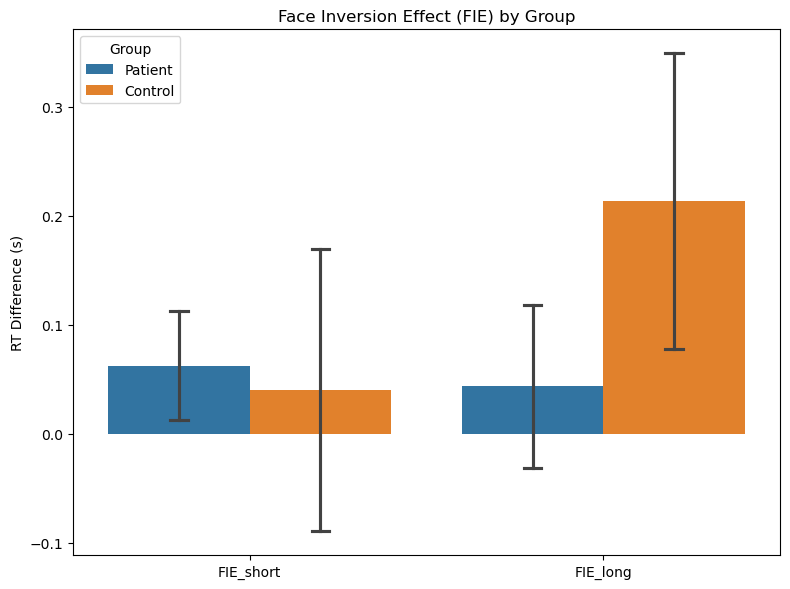

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# Reshape for plotting
plot_df = rt_pivot.melt(
    id_vars='group',
    value_vars=['FIE_short', 'FIE_long'],
    var_name='Condition',
    value_name='FIE'
)

# Plot with corrected errorbar argument
plt.figure(figsize=(8, 6))
sns.barplot(data=plot_df, x='Condition', y='FIE', hue='group', errorbar='se', capsize=0.1)

plt.title('Face Inversion Effect (FIE) by Group')
plt.ylabel('RT Difference (s)')
plt.xlabel('')
plt.legend(title='Group')
plt.tight_layout()
plt.show()


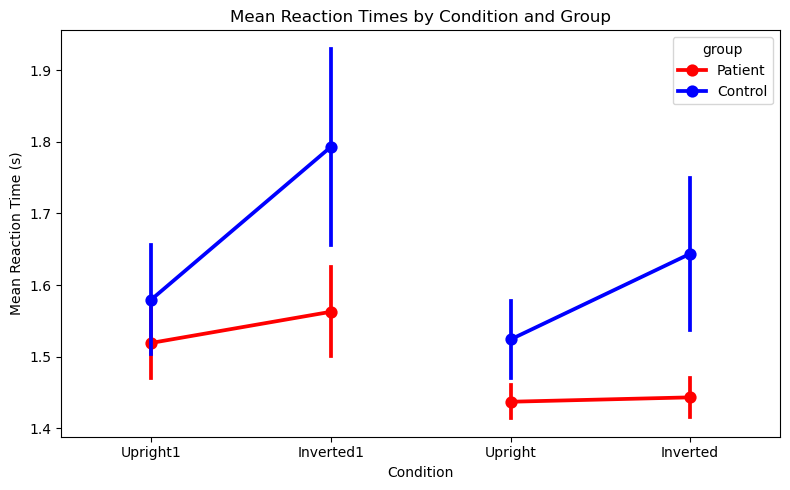

T-Tests and Group Means:

Condition: Upright1
  Patient Mean: 1.5193
  Control Mean: 1.5798
  t = -0.669, p = 0.5107

Condition: Inverted1
  Patient Mean: 1.5628
  Control Mean: 1.7930
  t = -1.530, p = 0.1442

Condition: Upright
  Patient Mean: 1.4372
  Control Mean: 1.5241
  t = -1.491, p = 0.1563

Condition: Inverted
  Patient Mean: 1.4433
  Control Mean: 1.6438
  t = -1.831, p = 0.0891


In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.api.types import CategoricalDtype

# Assign group
summary_df['group'] = summary_df['subject'].apply(lambda x: 'Patient' if str(x).startswith('1') else 'Control')

# Remove outliers (> 3 SD from condition mean)
def remove_outliers(df, column='mean_rt'):
    cleaned_df = pd.DataFrame()
    for cond in df['condition'].unique():
        subset = df[df['condition'] == cond]
        mean = subset[column].mean()
        std = subset[column].std()
        filtered = subset[(subset[column] >= mean - 3*std) & (subset[column] <= mean + 3*std)]
        cleaned_df = pd.concat([cleaned_df, filtered])
    return cleaned_df

summary_df = remove_outliers(summary_df)

# Define desired order and labels
condition_order = ['trials_upright1', 'trials_inverted1', 'trials_upright', 'trials_inverted']
condition_labels = ['Upright1', 'Inverted1', 'Upright', 'Inverted']
label_map = dict(zip(condition_order, condition_labels))
summary_df['condition_pretty'] = summary_df['condition'].map(label_map)

# Set proper categorical order
cat_type = CategoricalDtype(categories=['Upright1', 'Inverted1', 'Upright', 'Inverted'], ordered=True)
summary_df['condition_pretty'] = summary_df['condition_pretty'].astype(cat_type)
summary_df['mean_rt'] = 10 ** summary_df['mean_rt']

# Create the plot
plt.figure(figsize=(8, 5))

# Plot Upright1 ↔ Inverted1
sns.pointplot(
    data=summary_df[summary_df['condition_pretty'].isin(['Upright1', 'Inverted1'])],
    x='condition_pretty',
    y='mean_rt',
    hue='group',
    palette={'Patient': 'red', 'Control': 'blue'},
    errorbar='se',
    markers='o',
    linestyles='-'
)

# Plot Upright ↔ Inverted
sns.pointplot(
    data=summary_df[summary_df['condition_pretty'].isin(['Upright', 'Inverted'])],
    x='condition_pretty',
    y='mean_rt',
    hue='group',
    palette={'Patient': 'red', 'Control': 'blue'},
    errorbar='se',
    markers='o',
    linestyles='-',
    legend=False  # Avoid duplicate legends
)

plt.title('Mean Reaction Times by Condition and Group')
plt.ylabel('Mean Reaction Time (s)')
plt.xlabel('Condition')
plt.tight_layout()
plt.show()

print("T-Tests and Group Means:")
for cond in condition_order:
    data = summary_df[summary_df['condition'] == cond]
    patients = data[data['group'] == 'Patient']['mean_rt']
    controls = data[data['group'] == 'Control']['mean_rt']
    tstat, pval = ttest_ind(patients, controls, equal_var=False)
    print(f"\nCondition: {label_map[cond]}")
    print(f"  Patient Mean: {patients.mean():.4f}")
    print(f"  Control Mean: {controls.mean():.4f}")
    print(f"  t = {tstat:.3f}, p = {pval:.4f}")

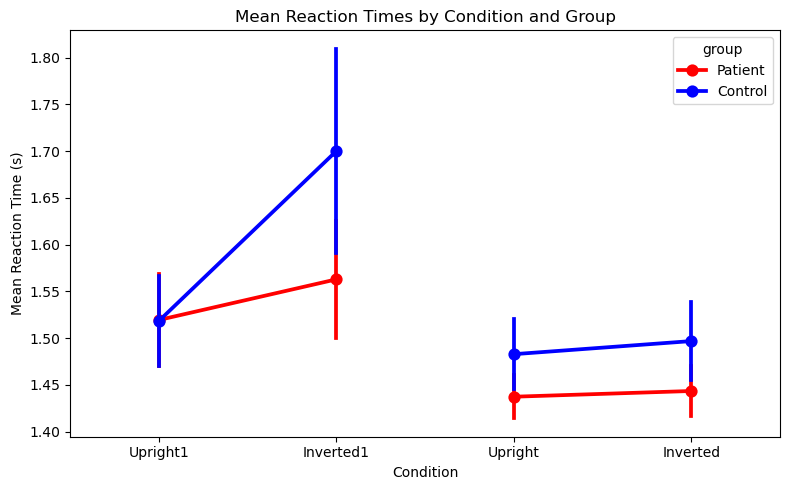

T-Tests and Group Means:

Condition: Upright1
  Patient Mean: 1.5193
  Control Mean: 1.5184
  t = 0.013, p = 0.9895

Condition: Inverted1
  Patient Mean: 1.5628
  Control Mean: 1.7001
  t = -1.091, p = 0.2894

Condition: Upright
  Patient Mean: 1.4372
  Control Mean: 1.4827
  t = -1.041, p = 0.3118

Condition: Inverted
  Patient Mean: 1.4433
  Control Mean: 1.4967
  t = -1.066, p = 0.3002


In [8]:
## graphing raw not log RT

import matplotlib.pyplot as plt
import seaborn as sns
from pandas.api.types import CategoricalDtype

# Assign group
summary_df['group'] = summary_df['subject'].apply(lambda x: 'Patient' if str(x).startswith('1') else 'Control')

# Remove outliers (> 3 SD from condition mean)
def remove_outliers(df, column='mean_rt'):
    cleaned_df = pd.DataFrame()
    for cond in df['condition'].unique():
        subset = df[df['condition'] == cond]
        mean = subset[column].mean()
        std = subset[column].std()
        filtered = subset[(subset[column] >= mean - 3*std) & (subset[column] <= mean + 3*std)]
        cleaned_df = pd.concat([cleaned_df, filtered])
    return cleaned_df

summary_df = remove_outliers(summary_df)

# Define desired order and labels
condition_order = ['trials_upright1', 'trials_inverted1', 'trials_upright', 'trials_inverted']
condition_labels = ['Upright1', 'Inverted1', 'Upright', 'Inverted']
label_map = dict(zip(condition_order, condition_labels))
summary_df['condition_pretty'] = summary_df['condition'].map(label_map)

# Set proper categorical order
cat_type = CategoricalDtype(categories=['Upright1', 'Inverted1', 'Upright', 'Inverted'], ordered=True)
summary_df['condition_pretty'] = summary_df['condition_pretty'].astype(cat_type)

# Create the plot
plt.figure(figsize=(8, 5))

# Plot Upright1 ↔ Inverted1
sns.pointplot(
    data=summary_df[summary_df['condition_pretty'].isin(['Upright1', 'Inverted1'])],
    x='condition_pretty',
    y='mean_rt',
    hue='group',
    palette={'Patient': 'red', 'Control': 'blue'},
    errorbar='se',
    markers='o',
    linestyles='-'
)

# Plot Upright ↔ Inverted
sns.pointplot(
    data=summary_df[summary_df['condition_pretty'].isin(['Upright', 'Inverted'])],
    x='condition_pretty',
    y='mean_rt',
    hue='group',
    palette={'Patient': 'red', 'Control': 'blue'},
    errorbar='se',
    markers='o',
    linestyles='-',
    legend=False  # Avoid duplicate legends
)

plt.title('Mean Reaction Times by Condition and Group')
plt.ylabel('Mean Reaction Time (s)')
plt.xlabel('Condition')
plt.tight_layout()
plt.show()

print("T-Tests and Group Means:")
for cond in condition_order:
    data = summary_df[summary_df['condition'] == cond]
    patients = data[data['group'] == 'Patient']['mean_rt']
    controls = data[data['group'] == 'Control']['mean_rt']
    tstat, pval = ttest_ind(patients, controls, equal_var=False)
    print(f"\nCondition: {label_map[cond]}")
    print(f"  Patient Mean: {patients.mean():.4f}")
    print(f"  Control Mean: {controls.mean():.4f}")
    print(f"  t = {tstat:.3f}, p = {pval:.4f}")

## REDOING W ACCURACY


In [7]:
import os
import pandas as pd

# Path to the top-level behavior folder
root_dir = '/Volumes/Seagate Desktop Drive/AVP-BDD/behavior'

# Trial conditions and their respective response key column prefixes
sheet_config = {
    'trials_upright': 'key_resp_upright',
    'trials_upright1': 'key_resp_upright',
    'trials_inverted': 'key_resp_inverted',
    'trials_inverted1': 'key_resp_inverted'
}

# Response key mapping
correct_map = {1: 'left', 2: 'right'}

# Store all summary data
summary_data = []

# Loop through subject folders
for subj in os.listdir(root_dir):
    subj_path = os.path.join(root_dir, subj, 'face-inversion-task')
    
    if not os.path.isdir(subj_path):
        continue

    # Find Excel file in the folder
    excel_files = [f for f in os.listdir(subj_path) if f.endswith('.xlsx')]
    if not excel_files:
        print(f"No Excel file found for subject {subj}")
        continue

    file_path = os.path.join(subj_path, excel_files[0])

    # Loop through each sheet
    for sheet_name, prefix in sheet_config.items():
        try:
            df = pd.read_excel(file_path, sheet_name=sheet_name).iloc[:28]
        except Exception as e:
            print(f"Skipping {sheet_name} for subject {subj}: {e}")
            continue

        # Construct dynamic column names
        key_col = f'{prefix}.keys_raw'
        rt_col = f'{prefix}.duration_raw'

        # Skip if key column is missing
        if key_col not in df.columns or rt_col not in df.columns:
            print(f"Missing columns in {sheet_name} for subject {subj}")
            continue

        # Clean key responses (strip quotes)
        df[key_col] = df[key_col].astype(str).str.strip("'")

        # Compute accuracy
        df['is_correct'] = df.apply(
            lambda row: correct_map.get(row['correct_resp']) == row[key_col], axis=1
        )

        # Compute mean RT
        df[rt_col] = pd.to_numeric(df[rt_col], errors='coerce')  # Force to float, handle strings
        mean_rt = df[rt_col].mean()
        accuracy = df['is_correct'].mean()

        # Store results
        summary_data.append({
            'subject': subj,
            'condition': sheet_name,
            'mean_rt': mean_rt,
            'accuracy': accuracy
        })

# Final summary
summary_df = pd.DataFrame(summary_data)
print(summary_df)

# Optional: Save to file
summary_df.to_excel('face_inversion_summary.xlsx', index=False)


    subject         condition   mean_rt  accuracy
0       102    trials_upright  0.123872  0.964286
1       102   trials_upright1  0.156612  1.000000
2       102   trials_inverted  0.124560  0.928571
3       102  trials_inverted1  0.152567  0.892857
4       103    trials_upright  0.139124  0.892857
..      ...               ...       ...       ...
119     218  trials_inverted1  0.137664  0.928571
120     222    trials_upright  0.149273  0.892857
121     222   trials_upright1  0.191669  0.892857
122     222   trials_inverted  0.152250  0.714286
123     222  trials_inverted1  0.146957  0.892857

[124 rows x 4 columns]


In [8]:
## CALCULATING FACE INVERSION EFFECT 

#comment out to not have outlier removal 
# Remove outliers (> 3 SD from condition mean)
# def remove_outliers(df, column='accuracy'):
#     cleaned_df = pd.DataFrame()
#     for cond in df['condition'].unique():
#         subset = df[df['condition'] == cond]
#         mean = subset[column].mean()
#         std = subset[column].std()
#         filtered = subset[(subset[column] >= mean - 3*std) & (subset[column] <= mean + 3*std)]
#         cleaned_df = pd.concat([cleaned_df, filtered])
#     return cleaned_df

# summary_df = remove_outliers(summary_df)

rt_pivot = summary_df.pivot(index='subject', columns='condition', values='accuracy').reset_index()

# Calculate FIE_short and FIE_long
rt_pivot['FIE_short'] = rt_pivot['trials_inverted'] - rt_pivot['trials_upright']
rt_pivot['FIE_long'] = rt_pivot['trials_inverted1'] - rt_pivot['trials_upright1']

# Optional: Save this to Excel
rt_pivot.to_excel('face_inversion_effects.xlsx', index=False)

# Print results
print(rt_pivot[['subject', 'FIE_short', 'FIE_long']])


condition subject  FIE_short  FIE_long
0             102  -0.035714 -0.107143
1             103  -0.071429 -0.178571
2             104  -0.321429 -0.107143
3             105   0.000000 -0.107143
4             106  -0.178571 -0.321429
5             107  -0.142857 -0.071429
6             108  -0.285714 -0.142857
7             109  -0.178571 -0.035714
8             110  -0.071429 -0.250000
9             111   0.035714  0.071429
10            112   0.035714 -0.071429
11            113  -0.035714  0.035714
12            115   0.000000  0.035714
13            116  -0.035714  0.000000
14            117  -0.035714  0.035714
15            118  -0.178571 -0.142857
16            120  -0.142857 -0.035714
17            121  -0.035714 -0.071429
18            124  -0.142857  0.000000
19            126  -0.250000 -0.285714
20            208  -0.285714 -0.035714
21            209  -0.142857  0.107143
22            210  -0.142857 -0.178571
23            211  -0.107143 -0.214286
24            212  -0.142

In [9]:
# Add group label based on subject ID prefix
def classify_group(subj):
    subj_num = int(subj)
    if 100 <= subj_num < 200:
        return 'Patient'
    elif 200 <= subj_num < 300:
        return 'Control'
    else:
        return 'Other'

rt_pivot['group'] = rt_pivot['subject'].apply(classify_group)

from scipy.stats import ttest_ind

# Separate groups
patients = rt_pivot[rt_pivot['group'] == 'Patient']
controls = rt_pivot[rt_pivot['group'] == 'Control']

# T-tests
t_short, p_short = ttest_ind(patients['FIE_short'], controls['FIE_short'], equal_var=False)
t_long, p_long = ttest_ind(patients['FIE_long'], controls['FIE_long'], equal_var=False)

print(f"FIE_short t-test: t = {t_short:.3f}, p = {p_short:.3f}")
print(f"FIE_long t-test:  t = {t_long:.3f}, p = {p_long:.3f}")


FIE_short t-test: t = 0.482, p = 0.634
FIE_long t-test:  t = 0.255, p = 0.801


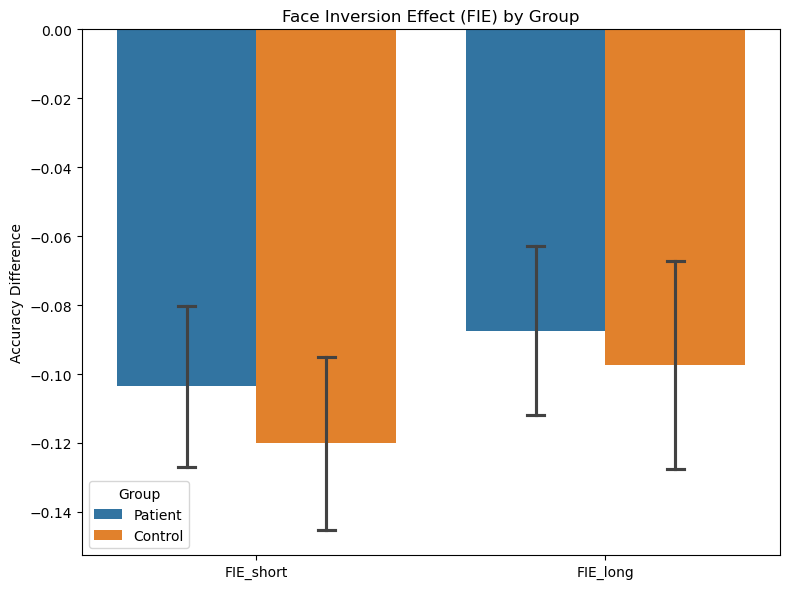

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# Reshape for plotting
plot_df = rt_pivot.melt(
    id_vars='group',
    value_vars=['FIE_short', 'FIE_long'],
    var_name='Condition',
    value_name='FIE'
)

# Plot with corrected errorbar argument
plt.figure(figsize=(8, 6))
sns.barplot(data=plot_df, x='Condition', y='FIE', hue='group', errorbar='se', capsize=0.1)

plt.title('Face Inversion Effect (FIE) by Group')
plt.ylabel('Accuracy Difference')
plt.xlabel('')
plt.legend(title='Group')
plt.tight_layout()
plt.show()


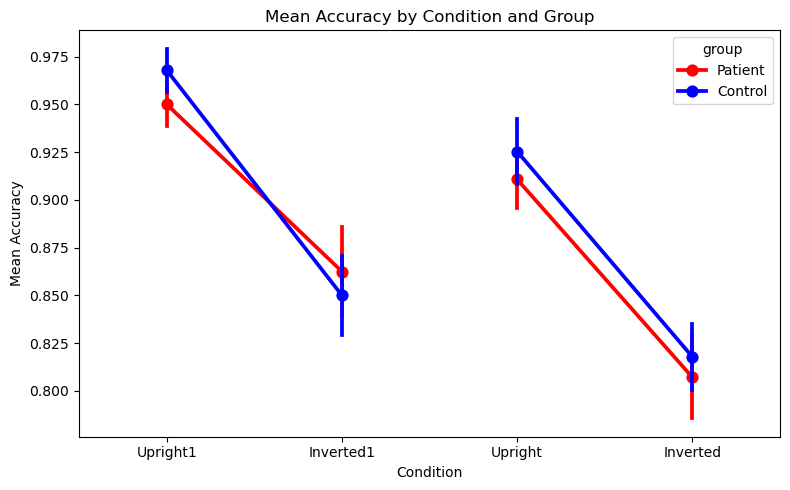

T-Tests and Group Means:

Condition: Upright1
  Patient Mean: 0.9500
  Control Mean: 0.9679
  t = -1.115, p = 0.2755

Condition: Inverted1
  Patient Mean: 0.8625
  Control Mean: 0.8500
  t = 0.404, p = 0.6896

Condition: Upright
  Patient Mean: 0.9107
  Control Mean: 0.9253
  t = -0.645, p = 0.5253

Condition: Inverted
  Patient Mean: 0.8071
  Control Mean: 0.8179
  t = -0.390, p = 0.6997


In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.api.types import CategoricalDtype

# Assign group
summary_df['group'] = summary_df['subject'].apply(lambda x: 'Patient' if str(x).startswith('1') else 'Control')

# # Remove outliers (> 3 SD from condition mean)
# def remove_outliers(df, column='mean_rt'):
#     cleaned_df = pd.DataFrame()
#     for cond in df['condition'].unique():
#         subset = df[df['condition'] == cond]
#         mean = subset[column].mean()
#         std = subset[column].std()
#         filtered = subset[(subset[column] >= mean - 3*std) & (subset[column] <= mean + 3*std)]
#         cleaned_df = pd.concat([cleaned_df, filtered])
#     return cleaned_df

# summary_df = remove_outliers(summary_df)

# Define desired order and labels
condition_order = ['trials_upright1', 'trials_inverted1', 'trials_upright', 'trials_inverted']
condition_labels = ['Upright1', 'Inverted1', 'Upright', 'Inverted']
label_map = dict(zip(condition_order, condition_labels))
summary_df['condition_pretty'] = summary_df['condition'].map(label_map)

# Set proper categorical order
cat_type = CategoricalDtype(categories=['Upright1', 'Inverted1', 'Upright', 'Inverted'], ordered=True)
summary_df['condition_pretty'] = summary_df['condition_pretty'].astype(cat_type)

# Create the plot
plt.figure(figsize=(8, 5))

# Plot Upright1 ↔ Inverted1
sns.pointplot(
    data=summary_df[summary_df['condition_pretty'].isin(['Upright1', 'Inverted1'])],
    x='condition_pretty',
    y='accuracy',
    hue='group',
    palette={'Patient': 'red', 'Control': 'blue'},
    errorbar='se',
    markers='o',
    linestyles='-'
)

# Plot Upright ↔ Inverted
sns.pointplot(
    data=summary_df[summary_df['condition_pretty'].isin(['Upright', 'Inverted'])],
    x='condition_pretty',
    y='accuracy',
    hue='group',
    palette={'Patient': 'red', 'Control': 'blue'},
    errorbar='se',
    markers='o',
    linestyles='-',
    legend=False  # Avoid duplicate legends
)

plt.title('Mean Accuracy by Condition and Group')
plt.ylabel('Mean Accuracy')
plt.xlabel('Condition')
plt.tight_layout()
plt.show()


print("T-Tests and Group Means:")
for cond in condition_order:
    data = summary_df[summary_df['condition'] == cond]
    patients = data[data['group'] == 'Patient']['accuracy']
    controls = data[data['group'] == 'Control']['accuracy']
    tstat, pval = ttest_ind(patients, controls, equal_var=False)
    print(f"\nCondition: {label_map[cond]}")
    print(f"  Patient Mean: {patients.mean():.4f}")
    print(f"  Control Mean: {controls.mean():.4f}")
    print(f"  t = {tstat:.3f}, p = {pval:.4f}")